# Debrief
1. Good learning on types of SVM's. I reran notebook with his LinearSVC configuration. Mine wasn't optimized for large datasets.
2. He uses MLPClassifier as stacking model, I use random forests. => No, MLP is just another estimator he uses.
3. Smart that he looped training estimators, and then printing out their validation scores.
4. My trees were significantly underfitting because of max_leafs I set. Even though I set more estimators than him, it didn't help. Makes sense that putting more trees won't help when they are underfitting, as combining trees helps to mitigate variance, not bias. I reran with his configuration.
5. He has convoluted notes of exercise 9, main part of which is doing a stacking classifier. The main learning is to use full dataset because stacking classifier uses cross-validation. I lost 10k training examples because I held out validation set.




### Questions
1. What's the difference between SVC I'm importing, and LinearSVC he is importing?
2. My random forests and extra trees are doing much worse than his, by 10-14%! Why is that?

### Answers
1. Well, that explains my observation that svc training takes too long. LinearSVC is simpler, used for linear classification, and is optimized for large datasets.
2. My tree ensembles underfit because of max_leafs set to 16, while his can go as deep as needed. Even though I set 300 estimators vs his 100, they don't cut it, trees are too simple and combining them together doesn't help.Which makes sense as combining trees together doesn't mitigate bias, but mitigates variance.


---



# Exercise 8
> Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

### Data Prep

In [3]:
from sklearn.datasets import fetch_openml
import pandas as pd
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target


In [4]:
import matplotlib.pyplot as plt


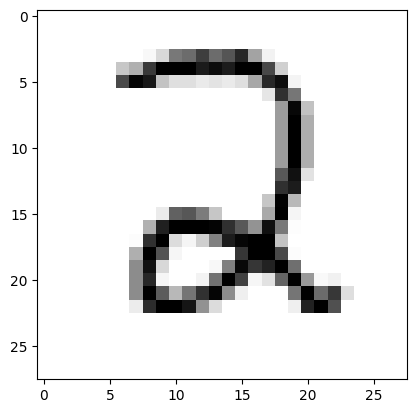

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  #plt.axis("off")
  plt.show()

plot_digit(X[432])


In [6]:
X_train, X_val, X_test = X[:50000], X[50000:60000], X[60000:]
y_train, y_val, y_test = y[:50000], y[50000:60000], y[60000:]

#print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
#print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
#print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

### Individual Model Training

In [7]:
# random forest tree classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_val)

rf_validation_score = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest validation accuracy: {rf_validation_score}")

Random Forest validation accuracy: 0.9736


In [8]:
# extra-trees classifier
from sklearn.ensemble import ExtraTreesClassifier
xt_clf = ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)
xt_clf.fit(X_train, y_train)
y_pred_xt = xt_clf.predict(X_val)

xt_validation_score = accuracy_score(y_val, y_pred_xt)
print(f"Extra Trees validation accuracy: {xt_validation_score}")

Extra Trees validation accuracy: 0.9743


In [9]:
# svm classifier
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_val)

svm_validation_score = accuracy_score(y_val, y_pred_svm)
print(f"SVM validation accuracy: {svm_validation_score}")

SVM validation accuracy: 0.8662


### Ensembles

In [10]:
# ensemble hard voting
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rnd_clf), ('xt', xt_clf)])

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_val)

voting_clf_validation_score = accuracy_score(y_val, y_pred_voting)
print(f"Voting Classifier validation accuracy: {voting_clf_validation_score}")


Voting Classifier validation accuracy: 0.9737


In [14]:
# ensemble soft voting
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Let CalibratedClassifierCV handle the fitting with cross-validation
svm_clf_for_soft_voting = CalibratedClassifierCV(
    LinearSVC(max_iter=100, tol=20, dual=True, random_state=42),
    method='sigmoid',
    cv=5  # This will fit the LinearSVC automatically during calibration
)

voting_clf_soft = VotingClassifier(
    estimators=[('rf', rnd_clf), ('xt', xt_clf), ('svm', svm_clf_for_soft_voting)],
    voting="soft"
)
voting_clf_soft.fit(X_train, y_train)
y_pred_voting = voting_clf_soft.predict(X_val)

voting_clf_soft_validation_score = accuracy_score(y_val, y_pred_voting)
print(f"Voting Classifier Soft validation accuracy: {voting_clf_soft_validation_score}")

Voting Classifier Soft validation accuracy: 0.9629


In [19]:
import numpy as np
from sklearn.metrics import accuracy_score

# Ensure y_test is of integer type for robust scoring
y_test_int = y_test.astype(np.int64)

# test set
y_pred_voting = voting_clf_soft.predict(X_test)

# FIX: Convert y_pred_voting to integer type for correct comparison
y_pred_voting_int = y_pred_voting.astype(np.int64)

voting_clf_test_score = accuracy_score(y_test_int, y_pred_voting_int)

print(f"Voting Classifier Soft test accuracy (ensemble): {voting_clf_test_score}")

# test set values of each predictor
print("\nIndividual Estimator Test Accuracies:")
for name, clf in voting_clf_soft.named_estimators_.items():
  # Use y_test_int for scoring individual classifiers
  print(name, "=", clf.score(X_test, y_test_int))

Voting Classifier Soft test accuracy (ensemble): 0.9566

Individual Estimator Test Accuracies:
rf = 0.968
xt = 0.9703
svm = 0.9029


# Exercise 9
> Exercise: Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [21]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators= [('rf', rnd_clf), ('xt', xt_clf), ('svm', svm_clf)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    cv=5)
stacking_clf.fit(X_train, y_train)
stacking_clf.score(X_test, y_test)

0.9747